In [ ]:
import copy
import json
from pathlib import Path

import numpy as np
import pandas as pd
import scipy

from zsl_config import ZSL_DIR_OUT_OLMO
from zsl_utils.mpl import *
from zsl_utils.wandb_parse import wandb2pandas
assert ZSL_DIR_OUT_OLMO.exists()

fig_dir = Path.cwd() /  'fig'
fig_dir.mkdir(parents=True, exist_ok=True)

## Load raw loss curves

In [3]:
def load_olmo_csvs(olmo_sizes):
    dfs = {}
    for olmo_size in olmo_sizes:
        _df = pd.read_csv(f'{olmo_size}-loss.csv')
        cols = _df.columns
        step_col = cols[0]
        loss_col = cols[1]
        df = pd.DataFrame({'loss': _df[loss_col], 'step': _df[step_col]})
        df.index = df['step']
        dfs[f'OLMo-{olmo_size}'] = df
    return dfs

In [5]:
OVERWRITE = False

RUNS = [
    '1028-rmsnorm-14m',
    '1028-rmsnorm-37m',
    '1028-rmsnorm-78m',
    '1028-rmsnorm-144m',
    '1028-rmsnorm-285m',
    '1028-rmsnorm-472m',
    ]
run_dirs = {
        run.split("-")[-1].replace('m', 'M'): ZSL_DIR_OUT_OLMO / run 
        for run in RUNS
    }
dfs = wandb2pandas(run_dirs, overwrite=OVERWRITE)
dfs.update(load_olmo_csvs(['1B', '7B']))

/network/scratch/m/mirceara/zsl_scratch/out/pretraining/olmo/1028-rmsnorm-14m/loss.csv already exists, loading from csv
/network/scratch/m/mirceara/zsl_scratch/out/pretraining/olmo/1028-rmsnorm-37m/loss.csv already exists, loading from csv
/network/scratch/m/mirceara/zsl_scratch/out/pretraining/olmo/1028-rmsnorm-78m/loss.csv already exists, loading from csv
/network/scratch/m/mirceara/zsl_scratch/out/pretraining/olmo/1028-rmsnorm-144m/loss.csv already exists, loading from csv
/network/scratch/m/mirceara/zsl_scratch/out/pretraining/olmo/1028-rmsnorm-285m/loss.csv already exists, loading from csv
/network/scratch/m/mirceara/zsl_scratch/out/pretraining/olmo/1028-rmsnorm-472m/loss.csv already exists, loading from csv


## Smooth and subsample loss curves

In [6]:
def moving_average(a, n=3):
    # simple moving average smoothing since losses are reported
    # for each step and very noisy
    a = np.concatenate([a[:1] for _ in range(n-1)] + [a])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def log_moving_average(x: np.ndarray, b: float = 1.2):
    x_lma = x * 0
    for j in range(0, len(x)):
        i = int(j // b)
        x_lma[j] = np.mean(x[i:j+1])

    return x_lma

def subsample_steps(steps, min_b10=3):
    # sample 1,2,3,..10,20,30,...,100,200,300 and so on
    # this reduces the outsized effect of (more numerous) post-deceleration 
    # steps when fitting the BNSL
    step_indices = [i for i,s in enumerate(steps) 
                    if s % 10**min(np.floor(np.log10(s)-1),min_b10)  == 0]
    step_indices += [len(steps)-1]
    return step_indices   

In [7]:
# skip first ~100 transient steps as in Kaplan et al. 2020
transient_steps = 100

preproc_curves = {}
for i, (run, df) in enumerate(dfs.items()):
    raw_steps = df.index.to_numpy()
    raw_losses = df["loss"].to_numpy()
    losses = log_moving_average(raw_losses)
    steps = raw_steps

    step_subsample = subsample_steps(raw_steps)
    steps = raw_steps[step_subsample]
    losses = losses[step_subsample]

    mask = steps > transient_steps
    steps = steps[mask]
    losses = losses[mask]

    preproc_curves[run] = (steps, losses)

/tmp/ipykernel_776112/662241393.py:22: RuntimeWarning: divide by zero encountered in log10
  if s % 10**min(np.floor(np.log10(s)-1),min_b10)  == 0]
/tmp/ipykernel_776112/662241393.py:22: RuntimeWarning: invalid value encountered in scalar remainder
  if s % 10**min(np.floor(np.log10(s)-1),min_b10)  == 0]


## Fit BNSL

In [8]:
def log_1b_bnsl(xlog, b, c0, c1, d1log, f1):
    ymalog = np.log(b) - c0*xlog - (c1*f1)*np.log(1+np.exp((xlog-d1log)/f1))
    return ymalog

def fit_1b_bnsl(x: np.ndarray, y: np.ndarray, d1_est: float = 6000):
    # initialize parameters with reasonable values (for stability)
    d1log = np.log(d1_est)
    xlog = np.log(x)
    ylog = np.log(y)
    d1_idx = np.argmin(np.abs(xlog - d1log))
    c0 = -np.mean((ylog[0:d1_idx] - ylog[1:d1_idx+1]) / (xlog[0:d1_idx] - xlog[1:d1_idx+1]))
    c1 = -np.mean((ylog[d1_idx:-2] - ylog[d1_idx+1:-1]) / (xlog[d1_idx:-2] - xlog[d1_idx+1:-1]))
    c1 = c1 - c0
    b = ylog[0] + c0*xlog[0]
    
    # fit parameters with scipy
    p0 = [b, c0, c1, d1log, 0.3]
    popt, pcov = scipy.optimize.curve_fit(
        log_1b_bnsl,
        xlog, ylog, 
        p0=p0,
        method='dogbox',
    )

    return popt, pcov

In [9]:
d1_est = 6_000        # set approximate d1 estimate for stability
bnsl_popt = {}
bnsl_pcov = {}
for run, (steps, losses) in preproc_curves.items():
    popt, pcov = fit_1b_bnsl(steps, losses, d1_est=d1_est)
    bnsl_popt[run] = popt
    bnsl_pcov[run] = pcov

## Plot BNSL

In [10]:
def single_line_list_json_dumps(d: dict, indent=2):
    def mark_list(dict_or_list):
        if isinstance(dict_or_list, list):
            if isinstance(dict_or_list[0], (list, dict)):
                for i,x in enumerate(dict_or_list):
                    dict_or_list[i] = mark_list(x)
            else:
                return "##<{}>##".format(dict_or_list)
        elif isinstance(dict_or_list, dict):
            for k,v in dict_or_list.items():
                if isinstance(v, (list, dict)):
                    dict_or_list[k] = mark_list(v)
            return dict_or_list
        else:
            raise Exception(f"Unexpected type {type(dict_or_list)}")

    _d = copy.deepcopy(d)
    mark_list(_d)
    json_str = json.dumps(_d, indent=indent)
    json_str = json_str.replace('"##<', '').replace('>##"', '')
    return json_str

/tmp/ipykernel_776112/662241393.py:22: RuntimeWarning: divide by zero encountered in log10
  if s % 10**min(np.floor(np.log10(s)-1),min_b10)  == 0]
/tmp/ipykernel_776112/662241393.py:22: RuntimeWarning: invalid value encountered in scalar remainder
  if s % 10**min(np.floor(np.log10(s)-1),min_b10)  == 0]


246035

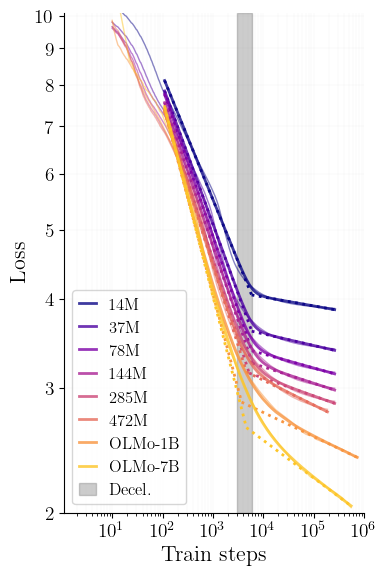

In [11]:
fig_path = fig_dir / f"bnsl_fit.pdf"
json_path = fig_path.with_suffix('.json')

fig, ax = plt.subplots(figsize=FIGSIZE_NARROW)
cmap = plt.get_cmap('plasma')
norm = Normalize(vmin=0, vmax=len(dfs))

plot_data = {}
def single_line_json_dumps(d: dict):
    def mark_list(dict_or_list):
        if isinstance(dict_or_list, list):
            if isinstance(dict_or_list[0], (list, dict)):
                for i,x in enumerate(dict_or_list):
                    dict_or_list[i] = mark_list(x)
            else:
                return "##<{}>##".format(dict_or_list)
        elif isinstance(dict_or_list, dict):
            for k,v in dict_or_list.items():
                if isinstance(v, (list, dict)):
                    dict_or_list[k] = mark_list(v)
            return dict_or_list
        else:
            raise Exception(f"Unexpected type {type(dict_or_list)}")



for i, (run, (steps, losses)) in enumerate(preproc_curves.items()):
    plot_data[run] = {}
    color = cmap(norm(i))
    xlog = np.log(steps)
    b, c0, c1, d1log, f1 = bnsl_popt[run]
    
    # plot data
    df = dfs[run]
    raw_steps = df.index.to_numpy()
    raw_losses = df["loss"].to_numpy()
    losses = log_moving_average(raw_losses, b=1.2)
    steps = raw_steps
    step_subsample = subsample_steps(raw_steps)
    steps = raw_steps[step_subsample]
    losses = losses[step_subsample]
    ax.plot(steps, losses, linewidth=1, alpha=0.5, color=color)
    plot_data[run]['smoothed_loss'] = {
        'x': steps.tolist(),
        'y': losses.tolist(),
    }

    # plot fit
    y_fit = np.exp(log_1b_bnsl(xlog, b, c0, c1, d1log, f1))
    x = np.exp(xlog)
    ax.plot(x, y_fit, label=f'{run}', linewidth=2, color=color, alpha=0.8)
    plot_data[run]['bnsl_fit'] = {
        'x': x.tolist(),
        'y': y_fit.tolist(),
    }

    # plot linear segments
    s1_xlog = [xlog[0], d1log]
    s1_ylog = [np.log(b) - c0*_x for _x in s1_xlog]
    s1_x = np.exp(s1_xlog)
    s1_y = np.exp(s1_ylog)
    ax.plot(s1_x, s1_y, linestyle=':', color=color, linewidth=2, alpha=1)
    plot_data[run]['bnsl_seg1'] = {
        'x': s1_x.tolist(),
        'y': s1_y.tolist(),
    }

    s2_xlog = [d1log, xlog[-1]]
    s2_ylog = [s1_ylog[-1] - (c0+c1)*(_x - d1log) for _x in s2_xlog]
    s2_x = np.exp(s2_xlog)
    s2_y = np.exp(s2_ylog)
    ax.plot(s2_x, s2_y, linestyle=':', color=color, linewidth=2, alpha=1)
    plot_data[run]['bnsl_seg2'] = {
        'x': s2_x.tolist(),
        'y': s2_y.tolist(),
    }
    
# axes.
xlabel = 'Train steps'
ylabel = 'Loss'
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_xscale('log')
ax.set_xlim(1.1, 1e6)
# HACK: make sure log scale ticks/grids are visible
ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))
ax.set_yscale('log')
ax.yaxis.set_ticks(list(range(2,11)))
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylim(2, 10.1)

# spines, grids and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linewidth=0.1, alpha=0.8, color='gray', linestyle='dotted', which='both')

ax.axvspan(3000, 6000, color='gray', alpha=0.4, 
           label='Decel.'
           )
ax.legend(
          loc='lower left',
            ncol=1,
            handlelength=1,
            fontsize=12, 
            # borderpad=0.3, labelspacing=0.2,handletextpad=0.2, columnspacing=0.4
          )

ax.set_position([0, 0, 1, 1])
fig.savefig(fig_path, format="pdf", bbox_inches='tight')
fig.savefig(fig_path.with_suffix('.png'), format="png", bbox_inches='tight')
# plt.show()

json_path.write_text(single_line_list_json_dumps(plot_data, indent=2))

## Generate tables

In [12]:
bnsl_data = {}

latex_table_bnsl = "Model & $b$ & $c_0$ & $c_1$ & $\log(d_1)$ & $f_1$ & RSLE \\\\ \n"
latex_table_decel = "Model && $L_d$ & $t_d$ & $r_d$ && $\hat{L}_T$ & $L_T$ \\\\ \n"
for run, popt in bnsl_popt.items():
    bnsl_data[run] = {}
    steps, losses = preproc_curves[run]
    pcov = bnsl_pcov[run]
    perr = np.sqrt(np.diag(pcov))

    # rsle
    y_fit = np.exp(log_1b_bnsl(np.log(steps), *popt))
    sle = (np.log(y_fit) - np.log(losses))**2    
    rsle = np.sqrt(np.mean(sle))

    b,c0,c1,d1log,f1 = popt
    
    bnsl_row = f"{run}"
    for k,v,e in zip(['b', 'c0', 'c1', 'd1log', 'f1'], popt, perr):
        bnsl_data[run][f'{k}_val'] = v
        bnsl_data[run][f'{k}_err'] = e
        bnsl_row += f" & ${v:.2f} \pm {e:.2f}$"
    bnsl_row += f" & ${rsle:.3f}$"
    bnsl_row += " \\\\ \n"
    latex_table_bnsl += bnsl_row

    d1 = int(np.exp(d1log))
    d1_min = int(np.exp(d1log - perr[3]))
    d1_max = int(np.exp(d1log + perr[3]))
    Ld = b*(d1)**(-c0)
    rd = c0 + c1
    t = steps[-1]
    Lt = np.exp(np.log(Ld) - rd*np.log(t/d1))
    Lt_actual = losses[-1]
    decel_row = f"{run} && ${Ld:.2f}$ & ${d1}$ & ${rd:.3f}$ & & ${Lt:.2f}$ & ${Lt_actual:.2f}$ \\\\ \n"   
    latex_table_decel += decel_row

    bnsl_data[run] |= {
        'd1': d1,
        'd1_min': d1_min,
        'd1_max': d1_max,
        'Ld': Ld,
        'rd': rd,
        'Lt': Lt,
        'Lt_actual': Lt_actual,
        'RSLE': rsle,
    }    

print("Latex table (BNSL)")
print(latex_table_bnsl)
print()
print("Latex table (Deceleration)")
print(latex_table_decel)
print()
print(json.dumps(bnsl_data, indent=2))

Latex table (BNSL)
Model & $b$ & $c_0$ & $c_1$ & $\log(d_1)$ & $f_1$ & RSLE \\ 
14M & $18.42 \pm 0.16$ & $0.17 \pm 0.00$ & $-0.16 \pm 0.00$ & $8.68 \pm 0.02$ & $0.20 \pm 0.03$ & $0.011$ \\ 
37M & $19.64 \pm 0.23$ & $0.20 \pm 0.00$ & $-0.18 \pm 0.00$ & $8.68 \pm 0.03$ & $0.24 \pm 0.03$ & $0.015$ \\ 
78M & $20.66 \pm 0.25$ & $0.21 \pm 0.00$ & $-0.19 \pm 0.00$ & $8.69 \pm 0.03$ & $0.29 \pm 0.03$ & $0.014$ \\ 
144M & $20.31 \pm 0.26$ & $0.21 \pm 0.00$ & $-0.19 \pm 0.00$ & $8.71 \pm 0.03$ & $0.34 \pm 0.03$ & $0.015$ \\ 
285M & $20.85 \pm 0.30$ & $0.22 \pm 0.00$ & $-0.20 \pm 0.00$ & $8.57 \pm 0.03$ & $0.44 \pm 0.03$ & $0.013$ \\ 
472M & $21.16 \pm 0.32$ & $0.23 \pm 0.00$ & $-0.19 \pm 0.00$ & $8.44 \pm 0.03$ & $0.39 \pm 0.04$ & $0.014$ \\ 
OLMo-1B & $25.97 \pm 0.38$ & $0.27 \pm 0.00$ & $-0.23 \pm 0.00$ & $8.22 \pm 0.03$ & $0.76 \pm 0.02$ & $0.008$ \\ 
OLMo-7B & $27.49 \pm 0.48$ & $0.28 \pm 0.00$ & $-0.22 \pm 0.00$ & $8.44 \pm 0.04$ & $0.76 \pm 0.03$ & $0.008$ \\ 


Latex table (Deceleration)
